In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import PolynomialFeatures
from scipy.integrate import simps
%matplotlib inline
#%precision 3

EPSILON = 10e-10 # to silence the RuntimeWarning: divide by zero encountered errors

In [34]:
ex2data2 = np.loadtxt("data/ex2data2.txt", delimiter=",")

exam_1_score = ex2data2[:, 0]

exam_1_score = ex2data2[:, 0]
exam_2_score = ex2data2[:, 1]

X = ex2data2[:, :-1]
y = ex2data2[:, -1]
exam_2_score = ex2data2[:, 1]

X = ex2data2[:, :-1]
y = ex2data2[:, -1]

In [55]:
class RLogisticRegression:

    def __init__(self,
                 X,
                 y,
                 alfa=0.001,
                 num_iter=100000,
                 fit_intercept=True,
                 weights_to_initialise=0):

        self.X = X
        self.y = y.reshape(len(y), 1)

        self._fit_intercept = fit_intercept
        self._alfa = alfa
        self._num_iter = num_iter
        self._m = X.shape[0]
        self._n = (X.shape[1] + 1) if fit_intercept else X.shape[1]

        self.thetas = None
        
        self._add_constant()
        self._initalise_θ(weights_to_initialise)


    def _add_constant(self):
        if self._fit_intercept:
            constants = np.ones((self._m, 1))
            self.X = np.concatenate((constants, self.X), axis=1)


    def _initalise_θ(self, weight_to_initialise):
        self.thetas = np.zeros(
            self._n
        ) + weight_to_initialise


    def _sigmoid(self, z):
        return (1 / (1 + np.exp(-z)))


    def _h(self):
        z = (self.X @ self.thetas.reshape(-1, 1))
        return self._sigmoid(z)


    def _calculate_cost(self, LAMBDA):
        h = self._h()
        regularisation = (LAMBDA / (2 * self._m)) * np.sum(np.square(self.thetas[1:]))

        J = -1 * (1 / self._m) * ((np.log(h).T @ y) + (np.log(1 - h).T @ (1 - y))) + regularisation
        return J[0]


    def _gradient(self, LAMBDA):
        h = self._h()
        regularisation = (LAMBDA / self._m) * self.thetas[1:]
        regularisation_theta_0_added = np.insert(regularisation, 0, 0, axis=0).reshape(self._n, 1)
        
        gradient = (1 / self._m) * self.X.T @ (h - self.y) + regularisation_theta_0_added
        return gradient.flatten()


    def fit(self, LAMBDA=1, verbose=False):
        print("COST: {}".format(self._calculate_cost(LAMBDA=LAMBDA)))
        for i in range(self._num_iter):
            self.thetas -= self._alfa * self._gradient(LAMBDA=LAMBDA)
            if (i % 10000 == 0):
                print("COST: {}".format(self._calculate_cost(LAMBDA=LAMBDA)))
                if verbose:
                    print("{}\n".format(self.thetas))


    def predict_prob(self):
        return self._sigmoid(self.X @ self.thetas)


    def predict_prob_single_instance(self, index):
        prob_matrix = self._sigmoid(self.X @ self.thetas)
        
        exam_scores = "Exam Score 1: %.3f\nExam Score 2: %.3f" % (self.X[index, 1], self.X[index, 2])
        probability = "Probability of Being Admitted: %.2f%%" % (prob_matrix[index] * 100)
        print(exam_scores); print(probability)


    def predict(self, threshold=0.5):
        prediction = self.predict_prob()
        prediction[prediction > threshold] = 1
        prediction[prediction <= threshold] = 0
        return prediction

In [56]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon=True, fancybox=True);


def calculate_model_performance(actual, predicted):
    TP = 0; TN = 0; FP = 0; FN = 0

    for act, pred in zip(actual, predicted):
        if act == 1:
            if act == pred:    TP += 1
            else:              FN += 1
        else:
            if act == pred:    TN += 1
            else:              FP += 1

    def specificity():
        return TN / (TN + FP + EPSILON) * 100

    def sensitivity_recall():
        return TP / (TP + FN + EPSILON) * 100

    def accuracy():
        return (TP + TN) / (TP + TN + FP + FN + EPSILON) * 100

    def prevalence():
        return (TP + FN) / (TP + TN + FP + FN + EPSILON) * 100

    def precision():
        return TP / (TP + FP + EPSILON) * 100
    
    def false_positive():
        return FP / (FP + TN + EPSILON) * 100
    
    def F1():
        return (2 * (
                (precision() * sensitivity_recall())
                / (precision() + sensitivity_recall() + EPSILON)
            ))

    model_metrics = {
        "specificty": specificity(),
        "sensitivity/recall": sensitivity_recall(),
        "accuracy": accuracy(),
        "prevalence": prevalence(),
        "precision": precision(),
        "F1": F1(),
        "false_positive_rate": false_positive()
    }
    return model_metrics


def plot_ROC(
    RLogReg_instance,
    threshold_spacing=50,
    verbose=False
):
    false_positive_rate = []
    true_positive_rate = []
    actual = RLogReg_instance.y

    for threshold in np.linspace(0, 1, threshold_spacing):
        predicted = RLogReg_instance.predict(threshold)
        model_metrics = calculate_model_performance(actual, predicted)
        false_positive_rate.append(model_metrics["false_positive_rate"])
        true_positive_rate.append(model_metrics["sensitivity/recall"])
        if verbose:
            print("Threshold: %.3f \nF1:%s\n" %(threshold, model_metrics["F1"]))
            
    #Here we multiply with -1 because recall is in decreasing order and therefore,
    #np.trapz returns a negative value. However, taking the integral of an equation
    #should return us the area under a curve which cannot be negative.
    AUC = -1 * np.trapz(y=true_positive_rate, x=false_positive_rate) 
    
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 100], [0, 100])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # AUC is divided by 100 here because in calculate_model_performance function,
    # these metrics are multiplied by 100
    plt.title("ROC Curve - AUC %.3f" %(AUC/100)) 
    plt.legend(["Logistic Regression", "Random guess"], loc='lower right');


def calculate_decision_boundary_values(coefficients, X):
    x1 = X[:, 1]
    x2 = (-1 / coefficients[2]) * (coefficients[0] + coefficients[1] * x1)
    return x1, x2


def plot_decision_boundary(coefficients, X):
    x1, x2 = calculate_decision_boundary_values(coefficients, X)
    plt.plot(x1,x2,'r-',label='Decision Boundary');


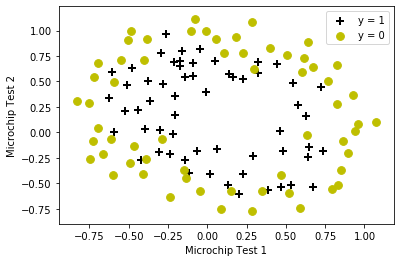

In [57]:
plotData(ex2data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

In [58]:
poly = PolynomialFeatures(6)
X_poly = poly.fit_transform(X)

In [80]:
self = RLogisticRegression(X_poly,
                           y,
                           alfa=0.2,
                           num_iter=10**6,
                           fit_intercept=False,
                           weights_to_initialise=0)

In [81]:
self.fit(LAMBDA=0, verbose=False)

COST: 0.6931471805599453
COST: 0.6906227241684947
COST: 0.3305883674678781
COST: 0.32282662246466587
COST: 0.31886231362628936
COST: 0.31624463083055077
COST: 0.3142662796188795
COST: 0.3126514216531743
COST: 0.31127363026300564
COST: 0.3100666051707643
COST: 0.30899117653383995
COST: 0.30802177616695775
COST: 0.30714036767838504
COST: 0.306333478637036
COST: 0.30559062391809144
COST: 0.3049034000749621
COST: 0.30426492698283014
COST: 0.3036694816567033
COST: 0.3031122452719777
COST: 0.3025891207836945
COST: 0.30209659687786306
COST: 0.3016316437132658
COST: 0.3011916313191004
COST: 0.30077426465625573
COST: 0.30037753125472494
COST: 0.29999965854122884
COST: 0.29963907875830453
COST: 0.29929439991026374
COST: 0.2989643815456009
COST: 0.2986479144550122
COST: 0.2983440035631293
COST: 0.2980517534418846
COST: 0.29777035598810303
COST: 0.2974990798969075
COST: 0.29723726163232195
COST: 0.29698429765170004
COST: 0.2967396376846453
COST: 0.2965027789024171
COST: 0.29627326084230343
COST: 0

## Model performance measurement metrics

[The link can be found here - type .pdf](http://www.academicos.ccadet.unam.mx/jorge.marquez/cursos/Instrumentacion/FalsePositive_TrueNegative_etc.pdf)

[Another link for the confusion matrix - type .pdf](https://www.lexjansen.com/nesug/nesug10/hl/hl07.pdf)

[Metrics explained - Towards Data Science(TDS) Article](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

[Metrics explained for non-technical - TDS Article](https://towardsdatascience.com/data-science-performance-metrics-for-everyone-4d68f4859eef)

In [76]:
calculate_model_performance(self.y, self.predict(threshold=0))

{'specificty': 0.0,
 'sensitivity/recall': 99.99999999827587,
 'accuracy': 49.15254237246481,
 'prevalence': 49.15254237246481,
 'precision': 49.15254237246481,
 'F1': 65.90909090790007,
 'false_positive_rate': 99.99999999833335}

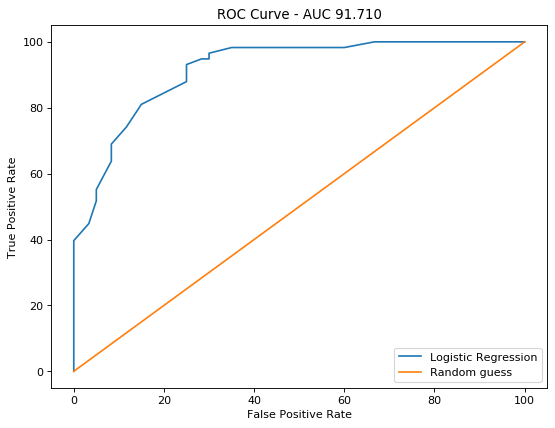

In [77]:
plot_ROC(RLogReg_instance=self)

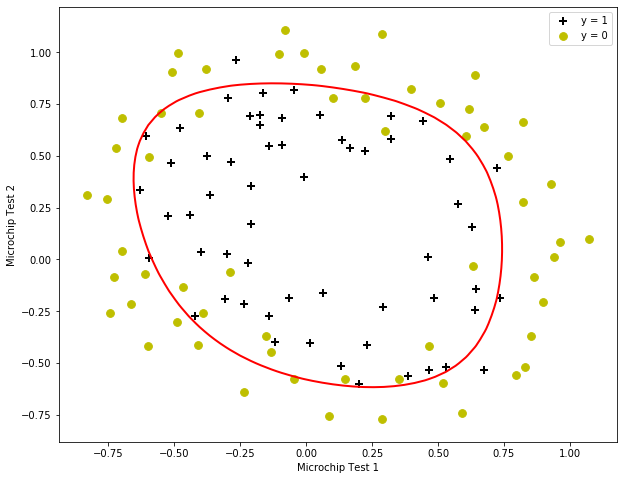

In [74]:
fig, axes = plt.subplots(1,1, sharey = True, figsize=(10,8))
plotData(ex2data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = self._sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(self.thetas))
h = h.reshape(xx1.shape)
axes.contour(xx1, xx2, h, [0.5], linewidths=2, colors='r');

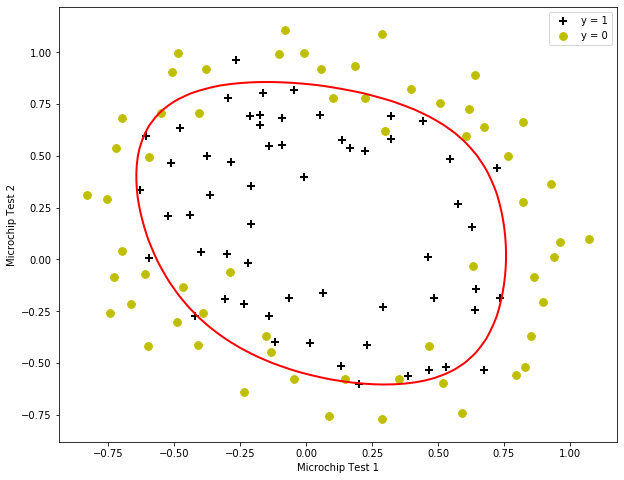

In [78]:
fig, axes = plt.subplots(1,1, sharey = True, figsize=(10,8))
plotData(ex2data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = self._sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(self.thetas))
h = h.reshape(xx1.shape)
axes.contour(xx1, xx2, h, [0.5], linewidths=2, colors='r');

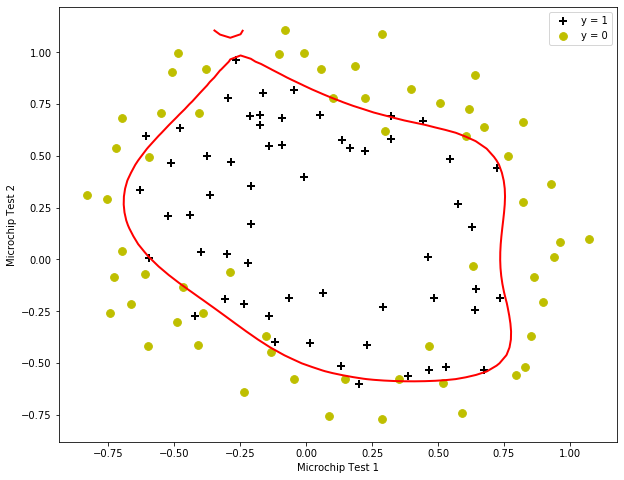

In [82]:
fig, axes = plt.subplots(1,1, sharey = True, figsize=(10,8))
plotData(ex2data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = self._sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(self.thetas))
h = h.reshape(xx1.shape)
axes.contour(xx1, xx2, h, [0.5], linewidths=2, colors='r');